In [1]:
import numpy as np
import matplotlib.pyplot as plt
from amalearn.agent import AgentBase
from amalearn.reward import RewardBase
import gym
from amalearn.environment import EnvironmentBase


In [2]:
import gym
from amalearn.environment import EnvironmentBase


class Q2MutliArmedBanditEnvironment(EnvironmentBase):
    def __init__(self, rewards, episode_max_length, id, container=None):
        state_space = gym.spaces.Discrete(1)
        action_space = gym.spaces.Discrete(len(rewards))

        super(Q2MutliArmedBanditEnvironment, self).__init__(action_space, state_space, id, container)
        self.arms_rewards = rewards
        self.episode_max_length = episode_max_length
        self.state = {
            'length': 0,
            'last_action': None
        }
        self.sigma = 0

    def get_info(self, action):
        return self.sigma

    def calculate_reward(self, action):
        reward , sigma = self.arms_rewards[action].get_reward()
        self.sigma = sigma
        return reward

    def terminated(self):
        return self.state['length'] >= self.episode_max_length

    def observe(self):
        return {}

    def available_actions(self):
        return self.action_space.n

    def next_state(self, action):
        self.state['length'] += 1
        self.state['last_action'] = action

    def reset(self):
        self.state['length'] = 0
        self.state['last_action'] = None

    def render(self, mode='human'):
        pass
        print('{}:\taction={}'.format(self.state['length'], self.state['last_action']))

    def close(self):
        return


In [3]:

class Q2EpsAgent(AgentBase):
    def __init__(self, id, environment, epsilon, learning_rate, status, alpha, beta, lambdaa):
        super(Q2EpsAgent, self).__init__(id, environment)
        self.epsilon = epsilon
        self.learning_rate = learning_rate
        self.status = status
        self.q_values = np.zeros(self.environment.available_actions())
        self.rewards = np.zeros(self.environment.available_actions())
        self.counts = np.zeros(self.environment.available_actions())
        self.available_actions = self.environment.available_actions()
        self.alpha = alpha
        self.beta = beta
        self.lambdaa = lambdaa
#         self.sigma = 0

    def select_action(self):
        available_actions = self.available_actions
        eps = self.epsilon

        best_action = np.argmax(self.q_values)
        random_action = np.random.choice(available_actions)

        prob_best_action = 1 - eps + (eps / available_actions)
        prob_random_action = eps / available_actions
        sum = prob_best_action + prob_random_action #normalize
        selected_action = np.random.choice([best_action, random_action], p=[prob_best_action/sum, prob_random_action/sum])
        return selected_action

    def update(self, action, r, inf):
        self.sigma = inf
        r = self.utility(r)
        self.rewards[action] += r
        self.counts[action] += 1
        self.q_values[action] = self.rewards[action] / self.counts[action]
        if self.status == "adaptive":
            self.epsilon = self.epsilon/2

    def utility(self, r):
        if self.sigma == np.inf:
            utility = r
        else:
            utility = r * self.sigma * 0.0005
        return utility

    def take_action(self) -> (object, float, bool, object):
        action = self.select_action()
        obs, r, d, inf = self.environment.step(action)
        print(obs, r, d, inf)
        self.update(action, r, inf)
        self.environment.render()
        return obs, r, d, inf

In [15]:
class Q2Reward(RewardBase):
    def __init__(self, mean, std, volume, price):
        super(Q2Reward, self).__init__()
        self.mean = mean
        self.std = std
        self.volume = volume
        self.price = price
        self.arg_selected_choice = None

    def calculate_arg_selected_choice(self):
        x = np.random.beta(2, 5, 1)[0]
        ratio = [x*p/v for p, v in zip(self.price, self.volume)]
        self.arg_selected_choice = np.argmin(ratio)

    def calculate_remained_price(self):
        i = self.arg_selected_choice
        used_volume = np.random.normal(loc=self.mean, scale=self.std)
        remained_volume = self.volume[i] - used_volume
        remained_price = remained_volume * (self.price[i]/self.volume[i])
        return remained_price

    def calculate_sigma(self, reward1, reward2, reward):
        i = self.arg_selected_choice
        if reward == reward1:
            if i == 0:
                sigma = self.price[i] - 3000
            else:
                sigma = self.price[i] - 1600
        if reward == reward2:
            sigma = np.inf
        return sigma

    def get_reward(self):
        self.calculate_arg_selected_choice()
        i = self.arg_selected_choice
        remained_price = self.calculate_remained_price()
        reward1 = remained_price + self.price[i]
        reward2 = -10
        reward = np.random.choice([reward1, reward2], p=[0.7, 0.3])
        sigma = self.calculate_sigma(reward1, reward2, reward)
        return reward, sigma


In [16]:
volume = [90, 250]
price1 = [3000, 3400, 3900]
price2 = [1600, 2000]

In [17]:
mean = 60
std = 5
rewards = []

for p1 in price1:
    for p2 in price2:
        rewards.append(Q2Reward(mean, std, volume, [p1, p2]))

In [33]:
[r.volume for r in rewards]

[[90, 250], [90, 250], [90, 250], [90, 250], [90, 250], [90, 250]]

In [27]:
[r.price for r in rewards]

[[3000, 1600],
 [3000, 2000],
 [3400, 1600],
 [3400, 2000],
 [3900, 1600],
 [3900, 2000]]

In [18]:
env = Q2MutliArmedBanditEnvironment(rewards, 1000, '2')

In [19]:
trials = 1000
rounds = 20
eps_total_rewards = np.zeros((trials, rounds))
for round in range(rounds):
    env.reset()
    agent = Q2EpsAgent(round, env, 0.8, 0.5, "const", 1, 1, 1)
    for trial in range(trials):
        agent.take_action()
        eps_total_rewards[trial][round] = sum(agent.rewards)/(trial+1)
eps_mean_reward = np.mean(eps_total_rewards, axis=1)

{} 2783.0068127729273 False 0
1:	action=0
{} 3464.3797381062 False 400
2:	action=3
{} -10.0 False inf
3:	action=3
{} -10.0 False inf
4:	action=3
{} -10.0 False inf
5:	action=3
{} -10.0 False inf
6:	action=0
{} -10.0 False inf
7:	action=3
{} 3521.657132654769 False 400
8:	action=3
{} 3456.430696845655 False 400
9:	action=3
{} 3567.901784670391 False 400
10:	action=3
{} -10.0 False inf
11:	action=3
{} 2760.6924010911166 False 0
12:	action=4
{} -10.0 False inf
13:	action=3
{} -10.0 False inf
14:	action=3
{} 3545.255247098674 False 400
15:	action=3
{} 3498.4047782752523 False 400
16:	action=3
{} 3543.1326726120515 False 400
17:	action=3
{} 3529.898356383323 False 400
18:	action=3
{} -10.0 False inf
19:	action=3
{} 3556.258512841446 False 400
20:	action=3
{} -10.0 False inf
21:	action=3
{} 3503.6551728377917 False 400
22:	action=3
{} 3502.6179789638627 False 400
23:	action=3
{} -10.0 False inf
24:	action=3
{} -10.0 False inf
25:	action=3
{} 2780.307164118577 False 0
26:	action=2
{} 2801.086

{} -10.0 False inf
373:	action=5
{} 3518.456469196601 False 400
374:	action=5
{} 3515.5338778337464 False 400
375:	action=5
{} 2866.482122825756 False 0
376:	action=4
{} 2752.769104639958 False 0
377:	action=0
{} 3495.3743410881434 False 400
378:	action=5
{} 3525.195993274576 False 400
379:	action=5
{} 3551.4930166264658 False 400
380:	action=5
{} 3530.8649568712653 False 400
381:	action=5
{} 3539.552686528561 False 400
382:	action=5
{} -10.0 False inf
383:	action=5
{} 2793.7559340156276 False 0
384:	action=2
{} 3506.6792311206773 False 400
385:	action=5
{} 3524.151540101139 False 400
386:	action=5
{} 2824.589469448682 False 0
387:	action=0
{} 3512.712232667791 False 400
388:	action=5
{} -10.0 False inf
389:	action=0
{} -10.0 False inf
390:	action=4
{} 3512.49491959868 False 400
391:	action=5
{} 3533.3606893190868 False 400
392:	action=5
{} 3517.9522431423 False 400
393:	action=5
{} 2802.8025413642827 False 0
394:	action=0
{} -10.0 False inf
395:	action=5
{} 3526.305823939851 False 400

{} -10.0 False inf
735:	action=5
{} 2831.3116794052153 False 0
736:	action=2
{} 3599.531694847527 False 400
737:	action=5
{} -10.0 False inf
738:	action=5
{} 3517.867322337508 False 400
739:	action=5
{} 3491.0659348201384 False 400
740:	action=5
{} 3524.5587087074978 False 400
741:	action=5
{} -10.0 False inf
742:	action=5
{} 3462.898724732284 False 400
743:	action=5
{} -10.0 False inf
744:	action=5
{} 3595.1166759070593 False 400
745:	action=5
{} 3472.20032701172 False 400
746:	action=5
{} 2857.810725362025 False 0
747:	action=2
{} -10.0 False inf
748:	action=3
{} 3531.833635736095 False 400
749:	action=5
{} 3523.1595537978883 False 400
750:	action=5
{} 2875.8656116940156 False 0
751:	action=4
{} 3475.5209060177917 False 400
752:	action=5
{} 2848.1489724751273 False 0
753:	action=0
{} 3512.9842027095865 False 400
754:	action=5
{} 3558.908151485304 False 400
755:	action=5
{} 3499.0129112258182 False 400
756:	action=5
{} 2846.5675039584685 False 0
757:	action=4
{} 3525.406063012205 Fals

{} 3541.2413408699686 False 400
121:	action=1
{} 3505.0954252580373 False 400
122:	action=3
{} -10.0 False inf
123:	action=2
{} 3538.7582422055266 False 400
124:	action=3
{} 3478.943705090386 False 400
125:	action=3
{} -10.0 False inf
126:	action=3
{} 3508.173645235909 False 400
127:	action=3
{} 3541.59008323206 False 400
128:	action=3
{} 3466.477187001065 False 400
129:	action=1
{} -10.0 False inf
130:	action=3
{} 3505.2579215533806 False 400
131:	action=3
{} 3486.193628131185 False 400
132:	action=5
{} 3504.0103510885233 False 400
133:	action=3
{} 3640.1986670121164 False 400
134:	action=3
{} 3582.054107287904 False 400
135:	action=5
{} 3487.7425144415665 False 400
136:	action=3
{} 3513.741181650448 False 400
137:	action=3
{} 3536.374640495183 False 400
138:	action=3
{} 3545.8739133980544 False 400
139:	action=3
{} 3552.397545165684 False 400
140:	action=5
{} 3488.3011279469565 False 400
141:	action=3
{} 3582.135370344201 False 400
142:	action=3
{} 2829.8211897965557 False 0
143:	act

{} 3540.592661167484 False 400
463:	action=3
{} -10.0 False inf
464:	action=3
{} 3532.331408240323 False 400
465:	action=3
{} -10.0 False inf
466:	action=3
{} 3523.2096586372945 False 400
467:	action=3
{} -10.0 False inf
468:	action=3
{} 3543.5962483136836 False 400
469:	action=3
{} 3526.969238563164 False 400
470:	action=3
{} -10.0 False inf
471:	action=3
{} -10.0 False inf
472:	action=3
{} 3564.4336038008714 False 400
473:	action=3
{} 3522.315284242405 False 400
474:	action=3
{} -10.0 False inf
475:	action=3
{} -10.0 False inf
476:	action=3
{} 3541.595733844168 False 400
477:	action=3
{} 3532.330971563246 False 400
478:	action=3
{} -10.0 False inf
479:	action=3
{} 3527.595875452362 False 400
480:	action=3
{} 3533.5598352326247 False 400
481:	action=3
{} 3487.9911126458264 False 400
482:	action=3
{} -10.0 False inf
483:	action=4
{} -10.0 False inf
484:	action=3
{} 3499.924348704899 False 400
485:	action=3
{} 3459.0392821841583 False 400
486:	action=3
{} 3510.2811857324136 False 400
48

{} 3497.6888732531197 False 400
756:	action=1
{} 3499.1079437764465 False 400
757:	action=3
{} -10.0 False inf
758:	action=3
{} 2809.2343085609486 False 0
759:	action=0
{} -10.0 False inf
760:	action=1
{} 3509.5688341689847 False 400
761:	action=3
{} -10.0 False inf
762:	action=3
{} 3548.115953710375 False 400
763:	action=3
{} 3540.559632398211 False 400
764:	action=3
{} 2826.419538014582 False 0
765:	action=2
{} -10.0 False inf
766:	action=3
{} -10.0 False inf
767:	action=3
{} -10.0 False inf
768:	action=3
{} -10.0 False inf
769:	action=3
{} 2785.9207314618584 False 0
770:	action=2
{} -10.0 False inf
771:	action=3
{} -10.0 False inf
772:	action=3
{} 3517.433015214972 False 400
773:	action=3
{} 3494.3754585559054 False 400
774:	action=3
{} 3483.8019732907696 False 400
775:	action=3
{} -10.0 False inf
776:	action=2
{} 3525.7684870582125 False 400
777:	action=3
{} 2791.6475888273962 False 0
778:	action=2
{} 2798.7624467841997 False 0
779:	action=4
{} -10.0 False inf
780:	action=3
{} -10.

{} 3475.020164335825 False 400
50:	action=3
{} 3524.6553118397437 False 400
51:	action=3
{} 3496.546159258514 False 400
52:	action=3
{} 2820.2728812065534 False 0
53:	action=0
{} 2827.2162087645434 False 0
54:	action=0
{} 3457.941391538144 False 400
55:	action=3
{} 3541.028685295095 False 400
56:	action=3
{} 3498.9912262593452 False 400
57:	action=5
{} -10.0 False inf
58:	action=4
{} 2792.971840284049 False 0
59:	action=2
{} -10.0 False inf
60:	action=3
{} 3483.468132144156 False 400
61:	action=3
{} 3510.9545191393663 False 400
62:	action=3
{} 3508.5469309797627 False 400
63:	action=3
{} -10.0 False inf
64:	action=3
{} 2842.7134778288128 False 0
65:	action=4
{} -10.0 False inf
66:	action=2
{} -10.0 False inf
67:	action=3
{} -10.0 False inf
68:	action=5
{} -10.0 False inf
69:	action=3
{} -10.0 False inf
70:	action=3
{} 3463.543214845159 False 400
71:	action=3
{} -10.0 False inf
72:	action=5
{} 3521.698459603903 False 400
73:	action=3
{} 3518.528163088758 False 400
74:	action=3
{} 3549.5

{} 3484.0128476181158 False 400
442:	action=3
{} 3460.3145358717165 False 400
443:	action=3
{} 2818.6103376593665 False 0
444:	action=0
{} -10.0 False inf
445:	action=3
{} -10.0 False inf
446:	action=5
{} 3540.9923065845633 False 400
447:	action=3
{} -10.0 False inf
448:	action=3
{} 3533.9418002381744 False 400
449:	action=5
{} -10.0 False inf
450:	action=3
{} 2834.4330499490725 False 0
451:	action=0
{} 3532.7985361505152 False 400
452:	action=3
{} 3529.7227537644676 False 400
453:	action=3
{} 3467.9228123344888 False 400
454:	action=3
{} 3521.223116725864 False 400
455:	action=3
{} 3525.583612145454 False 400
456:	action=3
{} 3461.0247778089706 False 400
457:	action=3
{} 3555.4312911954516 False 400
458:	action=3
{} -10.0 False inf
459:	action=3
{} 3462.6842034322754 False 400
460:	action=3
{} 3532.731263331542 False 400
461:	action=3
{} 3515.197772292776 False 400
462:	action=3
{} 3520.089426399955 False 400
463:	action=3
{} 3521.8964160838977 False 400
464:	action=3
{} 3493.55814094

{} 3554.9206645391478 False 400
833:	action=1
{} 2790.1516284399695 False 0
834:	action=0
{} 3523.025830607258 False 400
835:	action=1
{} 3505.8126322814737 False 400
836:	action=1
{} 2787.2500437882964 False 0
837:	action=0
{} 3511.573274208601 False 400
838:	action=1
{} 3480.0932046170547 False 400
839:	action=1
{} 3534.9283770704415 False 400
840:	action=1
{} 3614.9658508312123 False 400
841:	action=1
{} 3440.0804508055803 False 400
842:	action=5
{} 3604.203754061247 False 400
843:	action=1
{} -10.0 False inf
844:	action=1
{} 3468.5236408435467 False 400
845:	action=1
{} 3508.342882311653 False 400
846:	action=1
{} 3504.902480584096 False 400
847:	action=1
{} 3514.7102722182262 False 400
848:	action=1
{} 3596.9378100417825 False 400
849:	action=1
{} -10.0 False inf
850:	action=1
{} 2838.586560853737 False 0
851:	action=4
{} 3602.480853825501 False 400
852:	action=1
{} 3547.2223822675505 False 400
853:	action=1
{} 3584.6670083377985 False 400
854:	action=1
{} -10.0 False inf
855:	act

{} 3597.54884220283 False 400
232:	action=3
{} 3538.707224927264 False 400
233:	action=3
{} 3431.3321539462886 False 400
234:	action=3
{} 3538.5812452142045 False 400
235:	action=3
{} 3476.183456017881 False 400
236:	action=3
{} 3567.699870363431 False 400
237:	action=3
{} -10.0 False inf
238:	action=3
{} 3495.784920535169 False 400
239:	action=3
{} 3543.1454067243826 False 400
240:	action=3
{} -10.0 False inf
241:	action=3
{} 2770.878569726332 False 0
242:	action=4
{} 3537.7765522845425 False 400
243:	action=3
{} 3584.534088269862 False 400
244:	action=1
{} 3539.1608855056065 False 400
245:	action=3
{} 3559.354222947216 False 400
246:	action=3
{} -10.0 False inf
247:	action=3
{} -10.0 False inf
248:	action=3
{} 2880.7672417554204 False 0
249:	action=0
{} 3477.9623003828697 False 400
250:	action=1
{} 3468.361491058124 False 400
251:	action=3
{} 3537.8698902350266 False 400
252:	action=3
{} -10.0 False inf
253:	action=2
{} 2817.4569156579764 False 0
254:	action=2
{} 2795.7889360794497 F

{} 3627.8906192913564 False 400
631:	action=3
{} 3558.202387863321 False 400
632:	action=5
{} -10.0 False inf
633:	action=3
{} -10.0 False inf
634:	action=3
{} 3468.3297171931813 False 400
635:	action=3
{} 3498.515096336824 False 400
636:	action=1
{} 3531.9275620680073 False 400
637:	action=5
{} -10.0 False inf
638:	action=1
{} -10.0 False inf
639:	action=2
{} -10.0 False inf
640:	action=3
{} -10.0 False inf
641:	action=0
{} 3494.932420249104 False 400
642:	action=3
{} -10.0 False inf
643:	action=3
{} 3542.6606514287 False 400
644:	action=3
{} -10.0 False inf
645:	action=3
{} 3484.6918631582903 False 400
646:	action=5
{} 2796.692920093281 False 0
647:	action=4
{} -10.0 False inf
648:	action=5
{} -10.0 False inf
649:	action=3
{} 2795.869595616932 False 0
650:	action=4
{} -10.0 False inf
651:	action=3
{} 3527.510881126182 False 400
652:	action=5
{} 3535.7938119412893 False 400
653:	action=3
{} 2821.427218565246 False 0
654:	action=2
{} 3464.7182915386256 False 400
655:	action=3
{} -10.0 

{} 2786.301037252293 False 0
31:	action=2
{} 3497.0800880766647 False 400
32:	action=5
{} 3530.298343434844 False 400
33:	action=5
{} -10.0 False inf
34:	action=1
{} -10.0 False inf
35:	action=5
{} -10.0 False inf
36:	action=2
{} 3491.421776812047 False 400
37:	action=5
{} 3584.8027795779954 False 400
38:	action=5
{} 3472.7527060795837 False 400
39:	action=5
{} -10.0 False inf
40:	action=5
{} -10.0 False inf
41:	action=5
{} -10.0 False inf
42:	action=5
{} 3517.278956261614 False 400
43:	action=5
{} 3496.389775467055 False 400
44:	action=5
{} -10.0 False inf
45:	action=5
{} 3490.2775494527596 False 400
46:	action=5
{} 2804.64468131547 False 0
47:	action=4
{} 3516.1709869879796 False 400
48:	action=5
{} 3531.1614171531396 False 400
49:	action=5
{} 2822.2748856627286 False 0
50:	action=2
{} -10.0 False inf
51:	action=5
{} 3475.645012952486 False 400
52:	action=5
{} 3534.148370456839 False 400
53:	action=5
{} 3588.103136086509 False 400
54:	action=5
{} 3540.6169921181454 False 400
55:	acti

{} 3564.29394947949 False 400
420:	action=3
{} -10.0 False inf
421:	action=3
{} -10.0 False inf
422:	action=3
{} -10.0 False inf
423:	action=3
{} 3478.5168454099066 False 400
424:	action=3
{} 3526.86032586095 False 400
425:	action=3
{} -10.0 False inf
426:	action=4
{} 3545.7216656873097 False 400
427:	action=3
{} 3540.420749521554 False 400
428:	action=3
{} 3484.646759977298 False 400
429:	action=3
{} 3542.619317965016 False 400
430:	action=3
{} 3537.233896693543 False 400
431:	action=3
{} 2804.501361762533 False 0
432:	action=2
{} -10.0 False inf
433:	action=5
{} 3483.8852374022454 False 400
434:	action=3
{} -10.0 False inf
435:	action=3
{} -10.0 False inf
436:	action=3
{} 3546.8103516360634 False 400
437:	action=3
{} 3513.0469029279666 False 400
438:	action=3
{} 3431.508081004418 False 400
439:	action=3
{} 3579.4081680190166 False 400
440:	action=3
{} 3522.327193516725 False 400
441:	action=3
{} 3486.445552499769 False 400
442:	action=3
{} 3474.6354931705623 False 400
443:	action=1
{

{} 3510.565103830506 False 400
803:	action=3
{} -10.0 False inf
804:	action=2
{} -10.0 False inf
805:	action=3
{} -10.0 False inf
806:	action=2
{} 3514.439974547844 False 400
807:	action=3
{} 3499.680618286725 False 400
808:	action=3
{} 3462.6860779805584 False 400
809:	action=1
{} 3499.3628579479077 False 400
810:	action=3
{} -10.0 False inf
811:	action=3
{} 3422.6529350293013 False 400
812:	action=3
{} 2828.4201875245935 False 0
813:	action=2
{} 3535.8282554635216 False 400
814:	action=3
{} 3491.7870778473707 False 400
815:	action=3
{} 3479.197570656024 False 400
816:	action=3
{} 3519.662688272014 False 400
817:	action=3
{} 3473.256148937678 False 400
818:	action=3
{} 3478.7491443356234 False 400
819:	action=3
{} 3548.902342516707 False 400
820:	action=3
{} -10.0 False inf
821:	action=3
{} 3560.545598285547 False 400
822:	action=3
{} 3496.6149797291237 False 400
823:	action=3
{} -10.0 False inf
824:	action=4
{} -10.0 False inf
825:	action=3
{} 3558.574185165676 False 400
826:	action=

{} -10.0 False inf
180:	action=3
{} 2874.15071994112 False 0
181:	action=2
{} 3485.289678993966 False 400
182:	action=3
{} 3515.116986554279 False 400
183:	action=3
{} 3540.236646668635 False 400
184:	action=3
{} 3535.6371807184505 False 400
185:	action=1
{} -10.0 False inf
186:	action=5
{} 2790.855520786944 False 0
187:	action=0
{} -10.0 False inf
188:	action=3
{} 3529.265540245709 False 400
189:	action=1
{} -10.0 False inf
190:	action=1
{} 3463.9873727675945 False 400
191:	action=3
{} -10.0 False inf
192:	action=3
{} -10.0 False inf
193:	action=3
{} 2801.2296814263273 False 0
194:	action=0
{} -10.0 False inf
195:	action=4
{} 3539.255925282475 False 400
196:	action=1
{} 3526.3799448006653 False 400
197:	action=1
{} 3559.3037195779416 False 400
198:	action=1
{} 3517.7728663682788 False 400
199:	action=1
{} -10.0 False inf
200:	action=1
{} 3457.918419906133 False 400
201:	action=1
{} -10.0 False inf
202:	action=2
{} -10.0 False inf
203:	action=1
{} 3539.201602492625 False 400
204:	actio

{} -10.0 False inf
621:	action=3
{} -10.0 False inf
622:	action=3
{} 2850.478496837124 False 0
623:	action=0
{} 3495.997937033201 False 400
624:	action=3
{} 3551.1514476398943 False 400
625:	action=3
{} 3541.4322892057116 False 400
626:	action=3
{} 3568.6542510539875 False 400
627:	action=3
{} 3531.086134982331 False 400
628:	action=3
{} 3550.3402063760573 False 400
629:	action=3
{} 3515.9378061560205 False 400
630:	action=3
{} 3572.87259856767 False 400
631:	action=3
{} -10.0 False inf
632:	action=5
{} 3455.168965474799 False 400
633:	action=3
{} 3473.239551878112 False 400
634:	action=3
{} 3548.0753961147207 False 400
635:	action=1
{} 3605.453239353574 False 400
636:	action=3
{} 3501.9099559894676 False 400
637:	action=3
{} 3541.7177316523125 False 400
638:	action=3
{} 3494.5829967662166 False 400
639:	action=3
{} 3535.0607300579222 False 400
640:	action=3
{} 3572.8927083116273 False 400
641:	action=5
{} 3461.5977358189066 False 400
642:	action=3
{} 3468.2676472360185 False 400
643:	

{} 3574.9809173561844 False 400
42:	action=5
{} 3495.170159622797 False 400
43:	action=1
{} 3485.0912274088328 False 400
44:	action=1
{} 3526.8668381499456 False 400
45:	action=1
{} 3494.421586644943 False 400
46:	action=1
{} 3507.8291681974792 False 400
47:	action=1
{} 2796.7153148147286 False 0
48:	action=2
{} 3560.7605505986767 False 400
49:	action=1
{} -10.0 False inf
50:	action=1
{} 3502.875889999165 False 400
51:	action=5
{} 3469.07226003795 False 400
52:	action=1
{} -10.0 False inf
53:	action=4
{} -10.0 False inf
54:	action=1
{} -10.0 False inf
55:	action=1
{} 3566.1272333470233 False 400
56:	action=5
{} 3490.0209875656888 False 400
57:	action=3
{} 3556.097869530238 False 400
58:	action=3
{} 3490.882119755489 False 400
59:	action=3
{} -10.0 False inf
60:	action=0
{} 3488.825005758462 False 400
61:	action=3
{} 3509.8056915631773 False 400
62:	action=3
{} -10.0 False inf
63:	action=3
{} 3562.5345736320896 False 400
64:	action=3
{} 3571.2477263513856 False 400
65:	action=3
{} 2797.

{} 3606.463043297 False 400
492:	action=5
{} 3491.7828659835595 False 400
493:	action=5
{} 3506.046913274469 False 400
494:	action=5
{} 3564.422737985874 False 400
495:	action=5
{} -10.0 False inf
496:	action=3
{} 3557.428864100589 False 400
497:	action=5
{} -10.0 False inf
498:	action=0
{} 3587.296912956748 False 400
499:	action=3
{} 3533.420790493701 False 400
500:	action=3
{} 3489.4686157888355 False 400
501:	action=5
{} -10.0 False inf
502:	action=5
{} 3537.277271605999 False 400
503:	action=5
{} 3612.6990673172468 False 400
504:	action=3
{} -10.0 False inf
505:	action=4
{} 3423.0048473939873 False 400
506:	action=5
{} 3466.771617213119 False 400
507:	action=5
{} 3447.7778347026942 False 400
508:	action=5
{} 3540.0259066219264 False 400
509:	action=5
{} 3494.822265040157 False 400
510:	action=5
{} -10.0 False inf
511:	action=5
{} 3429.436172003248 False 400
512:	action=1
{} 3458.0025664823847 False 400
513:	action=5
{} 3509.7286546612027 False 400
514:	action=5
{} 3513.777436908929

{} 3543.6254297743253 False 400
909:	action=5
{} 3485.4918279511076 False 400
910:	action=5
{} 3549.4375498101126 False 400
911:	action=5
{} 2788.8110396648553 False 0
912:	action=2
{} -10.0 False inf
913:	action=5
{} -10.0 False inf
914:	action=5
{} 3532.52039079896 False 400
915:	action=5
{} -10.0 False inf
916:	action=5
{} 2856.56284557034 False 0
917:	action=0
{} -10.0 False inf
918:	action=5
{} 3633.3953385767586 False 400
919:	action=5
{} 2833.157086735859 False 0
920:	action=2
{} 3501.4108115051667 False 400
921:	action=5
{} 3527.820118800665 False 400
922:	action=5
{} 3582.131084640334 False 400
923:	action=5
{} 3549.0089446660627 False 400
924:	action=5
{} 3504.402368714551 False 400
925:	action=5
{} 3514.6739230602516 False 400
926:	action=5
{} 3503.659678768292 False 400
927:	action=5
{} 3506.2660220827506 False 400
928:	action=5
{} 3552.647454240442 False 400
929:	action=5
{} 2804.667203897603 False 0
930:	action=2
{} -10.0 False inf
931:	action=5
{} 3482.223545650085 False

{} 3551.3691995973754 False 400
316:	action=3
{} 2832.4380324648237 False 0
317:	action=0
{} 2803.452463556495 False 0
318:	action=2
{} 3511.4300582545757 False 400
319:	action=3
{} -10.0 False inf
320:	action=4
{} 2808.5373349888177 False 0
321:	action=4
{} -10.0 False inf
322:	action=3
{} 3511.209302354491 False 400
323:	action=3
{} 3495.499002968217 False 400
324:	action=3
{} 3575.4754260437426 False 400
325:	action=3
{} -10.0 False inf
326:	action=3
{} -10.0 False inf
327:	action=3
{} 3484.5079459111475 False 400
328:	action=3
{} 2822.8184358350927 False 0
329:	action=4
{} 3509.735677772721 False 400
330:	action=3
{} 2800.0779261724792 False 0
331:	action=2
{} -10.0 False inf
332:	action=3
{} 2844.54697812578 False 0
333:	action=0
{} 3481.204092690062 False 400
334:	action=3
{} 3549.2606031199475 False 400
335:	action=3
{} -10.0 False inf
336:	action=3
{} 3465.825614965165 False 400
337:	action=1
{} 3548.4228741858788 False 400
338:	action=3
{} -10.0 False inf
339:	action=3
{} 3568

{} 3481.079686903465 False 400
668:	action=3
{} 3579.8785154796906 False 400
669:	action=3
{} 3467.1817083441547 False 400
670:	action=3
{} 3500.5080369358075 False 400
671:	action=3
{} -10.0 False inf
672:	action=3
{} -10.0 False inf
673:	action=3
{} 3527.8649054637863 False 400
674:	action=1
{} -10.0 False inf
675:	action=3
{} -10.0 False inf
676:	action=3
{} 3524.799763255604 False 400
677:	action=3
{} -10.0 False inf
678:	action=3
{} 3539.6679983693393 False 400
679:	action=3
{} 3484.382557324596 False 400
680:	action=3
{} 3472.0749981784197 False 400
681:	action=3
{} 2836.6409880500423 False 0
682:	action=4
{} 3523.127460479189 False 400
683:	action=3
{} 3495.888858222172 False 400
684:	action=3
{} -10.0 False inf
685:	action=3
{} 3497.97814937893 False 400
686:	action=3
{} -10.0 False inf
687:	action=3
{} 3584.48019247753 False 400
688:	action=3
{} 3515.2954660660944 False 400
689:	action=3
{} 3518.3828533501564 False 400
690:	action=3
{} 3570.973092378964 False 400
691:	action=3

{} -10.0 False inf
25:	action=1
{} -10.0 False inf
26:	action=1
{} -10.0 False inf
27:	action=1
{} 3483.487403921973 False 400
28:	action=1
{} 3550.3421819095042 False 400
29:	action=1
{} 3555.2078850969738 False 400
30:	action=1
{} 3533.869198621084 False 400
31:	action=1
{} 3494.3475200831576 False 400
32:	action=1
{} 2769.0489121046503 False 0
33:	action=0
{} 2821.060076306585 False 0
34:	action=2
{} 3456.7645018959774 False 400
35:	action=1
{} 3503.454292555868 False 400
36:	action=1
{} -10.0 False inf
37:	action=1
{} -10.0 False inf
38:	action=1
{} 3581.1873486354825 False 400
39:	action=1
{} 3506.6375337738577 False 400
40:	action=1
{} 2857.8000023258483 False 0
41:	action=0
{} 3582.2255312269704 False 400
42:	action=1
{} 3486.1992216200456 False 400
43:	action=1
{} -10.0 False inf
44:	action=1
{} 3491.7109472215907 False 400
45:	action=1
{} 2812.8952250748707 False 0
46:	action=4
{} 3499.378747098057 False 400
47:	action=1
{} 3559.1076084044603 False 400
48:	action=1
{} -10.0 Fa

{} 3506.6779792173684 False 400
421:	action=5
{} 3520.053334923804 False 400
422:	action=3
{} 3484.0096201270826 False 400
423:	action=3
{} 2814.278438019357 False 0
424:	action=4
{} 3457.0477500427996 False 400
425:	action=3
{} 3473.905748445549 False 400
426:	action=3
{} 3503.869422936048 False 400
427:	action=3
{} -10.0 False inf
428:	action=3
{} 3565.2642798174397 False 400
429:	action=3
{} 2789.9246255082276 False 0
430:	action=0
{} -10.0 False inf
431:	action=3
{} -10.0 False inf
432:	action=3
{} 3510.015676914258 False 400
433:	action=3
{} 3494.2388345525933 False 400
434:	action=3
{} 2762.566105568977 False 0
435:	action=2
{} -10.0 False inf
436:	action=4
{} 3535.21588816649 False 400
437:	action=3
{} -10.0 False inf
438:	action=3
{} 3567.3127094653864 False 400
439:	action=3
{} -10.0 False inf
440:	action=3
{} -10.0 False inf
441:	action=3
{} 3602.672803934952 False 400
442:	action=3
{} 3532.4217508039383 False 400
443:	action=3
{} 3534.30100768026 False 400
444:	action=1
{} 3

{} 3513.642279268844 False 400
786:	action=3
{} 2866.5833443400934 False 0
787:	action=2
{} 3471.345458814306 False 400
788:	action=3
{} -10.0 False inf
789:	action=3
{} 3476.617604491912 False 400
790:	action=3
{} 3501.875508589498 False 400
791:	action=3
{} 3508.4660387328527 False 400
792:	action=3
{} 3463.305567879825 False 400
793:	action=5
{} -10.0 False inf
794:	action=3
{} 2836.372006665778 False 0
795:	action=0
{} 3504.6880005573357 False 400
796:	action=3
{} 3459.4555996758936 False 400
797:	action=5
{} 3502.02601278936 False 400
798:	action=3
{} -10.0 False inf
799:	action=3
{} 3526.610855873727 False 400
800:	action=3
{} 3492.6472187346526 False 400
801:	action=3
{} 3566.0751592005845 False 400
802:	action=3
{} 2846.498951302843 False 0
803:	action=0
{} 3503.4902549692497 False 400
804:	action=3
{} 3593.340931625471 False 400
805:	action=3
{} 3532.887060244301 False 400
806:	action=1
{} 3495.3743529957646 False 400
807:	action=3
{} 3512.5731556909004 False 400
808:	action=5

{} 3577.5189672350216 False 400
137:	action=5
{} -10.0 False inf
138:	action=5
{} -10.0 False inf
139:	action=5
{} 3489.1636464444427 False 400
140:	action=1
{} 3509.5529985123244 False 400
141:	action=5
{} -10.0 False inf
142:	action=5
{} 3487.85766026504 False 400
143:	action=5
{} 3508.540314741254 False 400
144:	action=5
{} 3571.4099825991298 False 400
145:	action=5
{} -10.0 False inf
146:	action=5
{} 3538.951631250313 False 400
147:	action=3
{} 3530.477995994409 False 400
148:	action=3
{} 3558.825517706048 False 400
149:	action=3
{} -10.0 False inf
150:	action=2
{} -10.0 False inf
151:	action=3
{} 3528.1272909330823 False 400
152:	action=5
{} 3446.465360312929 False 400
153:	action=3
{} -10.0 False inf
154:	action=3
{} 3459.2322069884412 False 400
155:	action=5
{} 3534.772908453013 False 400
156:	action=5
{} 3535.2263756409634 False 400
157:	action=5
{} 3529.1899392613127 False 400
158:	action=5
{} 3533.756994823522 False 400
159:	action=5
{} 2808.5345696641552 False 0
160:	action=

{} -10.0 False inf
491:	action=5
{} 3508.3323186735292 False 400
492:	action=3
{} -10.0 False inf
493:	action=5
{} 3556.506711915833 False 400
494:	action=3
{} 3542.275918535841 False 400
495:	action=3
{} 3530.01101833912 False 400
496:	action=3
{} 3582.012818531456 False 400
497:	action=3
{} -10.0 False inf
498:	action=3
{} 3552.26560354337 False 400
499:	action=3
{} 3494.436114245384 False 400
500:	action=3
{} 3514.686208172694 False 400
501:	action=3
{} -10.0 False inf
502:	action=3
{} -10.0 False inf
503:	action=3
{} 3506.0596214767365 False 400
504:	action=3
{} 3438.176757583514 False 400
505:	action=3
{} 3529.771388122392 False 400
506:	action=3
{} 3595.2884522586073 False 400
507:	action=3
{} 3510.139559073941 False 400
508:	action=3
{} 3503.924873864578 False 400
509:	action=3
{} 3523.0394610836443 False 400
510:	action=3
{} -10.0 False inf
511:	action=3
{} 2866.3838986456194 False 0
512:	action=2
{} 3496.1059483055787 False 400
513:	action=3
{} -10.0 False inf
514:	action=3
{}

{} 3506.4215052612312 False 400
886:	action=3
{} 3525.741878244006 False 400
887:	action=3
{} 3503.5337306076535 False 400
888:	action=3
{} 3563.9664493818627 False 400
889:	action=3
{} 3563.3389386714907 False 400
890:	action=3
{} 3565.320688790186 False 400
891:	action=3
{} 3553.922937144591 False 400
892:	action=3
{} 3479.73230986218 False 400
893:	action=3
{} -10.0 False inf
894:	action=3
{} 3532.0271627858738 False 400
895:	action=3
{} 3469.1089777993056 False 400
896:	action=3
{} -10.0 False inf
897:	action=3
{} -10.0 False inf
898:	action=3
{} 3557.3849536533135 False 400
899:	action=3
{} 3523.387109257337 False 400
900:	action=3
{} 3599.042583181095 False 400
901:	action=3
{} 3536.654892670695 False 400
902:	action=3
{} 3532.58982243946 False 400
903:	action=3
{} 3516.8942339914893 False 400
904:	action=3
{} -10.0 False inf
905:	action=4
{} -10.0 False inf
906:	action=3
{} -10.0 False inf
907:	action=3
{} 3545.773621080488 False 400
908:	action=3
{} 2763.539968425569 False 0
90

{} -10.0 False inf
338:	action=1
{} 3477.3869563505423 False 400
339:	action=1
{} 3540.3305202649126 False 400
340:	action=5
{} 2816.37835459506 False 0
341:	action=4
{} 3535.448313044546 False 400
342:	action=1
{} 3479.173140165978 False 400
343:	action=1
{} 3523.880740496227 False 400
344:	action=1
{} 3563.2464663817727 False 400
345:	action=1
{} 3529.9213030457513 False 400
346:	action=1
{} 3434.091711108189 False 400
347:	action=1
{} 3544.976711864917 False 400
348:	action=1
{} 2792.034486467189 False 0
349:	action=4
{} 3485.0511903002753 False 400
350:	action=1
{} -10.0 False inf
351:	action=1
{} 2815.4199189741357 False 0
352:	action=2
{} -10.0 False inf
353:	action=4
{} 3463.4765994335753 False 400
354:	action=1
{} 3563.8644611296763 False 400
355:	action=1
{} 3507.31688208188 False 400
356:	action=3
{} -10.0 False inf
357:	action=5
{} 3489.2116752527977 False 400
358:	action=1
{} 3587.5493804058106 False 400
359:	action=1
{} 3508.003490695557 False 400
360:	action=1
{} 3454.099

{} 3551.813521571337 False 400
791:	action=1
{} -10.0 False inf
792:	action=1
{} 3525.5092440625203 False 400
793:	action=1
{} 3588.1752170435548 False 400
794:	action=5
{} 2875.1537706161153 False 0
795:	action=2
{} 2835.6481507296076 False 0
796:	action=2
{} 3541.077244428689 False 400
797:	action=1
{} -10.0 False inf
798:	action=1
{} 3502.9033266782462 False 400
799:	action=1
{} 3500.2952138428454 False 400
800:	action=1
{} -10.0 False inf
801:	action=5
{} 3516.905071423637 False 400
802:	action=1
{} -10.0 False inf
803:	action=4
{} 3528.3582711377394 False 400
804:	action=1
{} 3460.4364390075234 False 400
805:	action=1
{} -10.0 False inf
806:	action=5
{} -10.0 False inf
807:	action=1
{} 3593.4238059360505 False 400
808:	action=1
{} 3497.70504115492 False 400
809:	action=1
{} 3551.1087003700113 False 400
810:	action=1
{} 3523.805325344819 False 400
811:	action=1
{} 3547.649101138043 False 400
812:	action=1
{} -10.0 False inf
813:	action=1
{} 3514.441376252091 False 400
814:	action=1

{} 3452.9986410886113 False 400
219:	action=5
{} -10.0 False inf
220:	action=5
{} 3541.296623368412 False 400
221:	action=5
{} -10.0 False inf
222:	action=5
{} 3498.3721730047564 False 400
223:	action=5
{} 3500.825213233425 False 400
224:	action=5
{} -10.0 False inf
225:	action=5
{} 3497.963253984449 False 400
226:	action=5
{} 2838.555551092146 False 0
227:	action=0
{} -10.0 False inf
228:	action=5
{} -10.0 False inf
229:	action=5
{} 3547.8598853510325 False 400
230:	action=5
{} -10.0 False inf
231:	action=5
{} 3563.9311084908413 False 400
232:	action=5
{} -10.0 False inf
233:	action=5
{} 3421.7384591635787 False 400
234:	action=5
{} 3559.5068235119666 False 400
235:	action=5
{} 3526.490509617898 False 400
236:	action=5
{} 3532.9623332167707 False 400
237:	action=5
{} 3558.1499681278065 False 400
238:	action=5
{} -10.0 False inf
239:	action=5
{} 3552.919583827902 False 400
240:	action=5
{} 2802.9578297426297 False 0
241:	action=0
{} 3550.413069031686 False 400
242:	action=5
{} 3488.680

{} 3452.650624085475 False 400
630:	action=5
{} 3514.374895924845 False 400
631:	action=5
{} 3578.770562529313 False 400
632:	action=5
{} -10.0 False inf
633:	action=5
{} 3499.8913423007843 False 400
634:	action=5
{} 3540.132378095613 False 400
635:	action=5
{} 3500.4209246469068 False 400
636:	action=5
{} 3472.7780386396103 False 400
637:	action=5
{} -10.0 False inf
638:	action=5
{} 3420.4993032999537 False 400
639:	action=5
{} 2830.103547138529 False 0
640:	action=0
{} 3450.9856978293524 False 400
641:	action=5
{} 3469.021979291335 False 400
642:	action=5
{} 3531.184573018987 False 400
643:	action=5
{} 2818.1377647348263 False 0
644:	action=2
{} 3480.9556823478874 False 400
645:	action=5
{} 3557.200045786219 False 400
646:	action=5
{} -10.0 False inf
647:	action=5
{} 3516.938996075867 False 400
648:	action=5
{} -10.0 False inf
649:	action=5
{} -10.0 False inf
650:	action=5
{} 3521.9095610584036 False 400
651:	action=1
{} 3504.7761590280843 False 400
652:	action=5
{} 3585.462818032615

{} 3582.666135111808 False 400
994:	action=5
{} -10.0 False inf
995:	action=5
{} 2824.671970246616 False 0
996:	action=2
{} 3452.565299048789 False 400
997:	action=5
{} -10.0 False inf
998:	action=5
{} -10.0 False inf
999:	action=5
{} 3530.9463100889684 True 400
1000:	action=5
{} -10.0 False inf
1:	action=0
{} 3535.0887078559117 False 400
2:	action=1
{} 3584.080758418357 False 400
3:	action=1
{} -10.0 False inf
4:	action=3
{} 3422.199900946482 False 400
5:	action=1
{} 3519.021083040843 False 400
6:	action=1
{} 3572.9896944179663 False 400
7:	action=1
{} 3512.5563729502996 False 400
8:	action=1
{} 3516.0916317728124 False 400
9:	action=1
{} -10.0 False inf
10:	action=1
{} 3436.172855912998 False 400
11:	action=1
{} 3530.7883051670306 False 400
12:	action=1
{} -10.0 False inf
13:	action=1
{} -10.0 False inf
14:	action=1
{} 3554.0907418985776 False 400
15:	action=1
{} 2762.5957670734174 False 0
16:	action=2
{} 3482.8733941962146 False 400
17:	action=1
{} 3565.457367495029 False 400
18:	ac

{} 3533.904376985887 False 400
368:	action=5
{} -10.0 False inf
369:	action=3
{} 3495.3390971581825 False 400
370:	action=5
{} 3563.441788156201 False 400
371:	action=5
{} 3445.784592755891 False 400
372:	action=5
{} 2820.6147274943914 False 0
373:	action=2
{} 3507.185934777648 False 400
374:	action=5
{} 3506.779887971526 False 400
375:	action=5
{} 3501.795867024729 False 400
376:	action=1
{} -10.0 False inf
377:	action=4
{} -10.0 False inf
378:	action=5
{} -10.0 False inf
379:	action=5
{} -10.0 False inf
380:	action=5
{} 3530.0597148010334 False 400
381:	action=5
{} -10.0 False inf
382:	action=5
{} 3498.629381537445 False 400
383:	action=5
{} -10.0 False inf
384:	action=5
{} 3396.750434555385 False 400
385:	action=5
{} -10.0 False inf
386:	action=5
{} -10.0 False inf
387:	action=5
{} 2821.309987095602 False 0
388:	action=2
{} 3545.0205798421603 False 400
389:	action=1
{} 3486.65872181949 False 400
390:	action=5
{} 3523.1143294542144 False 400
391:	action=5
{} 3558.8558677558585 False 

{} 3518.205420774755 False 400
781:	action=5
{} 3588.0473200209694 False 400
782:	action=5
{} 3509.979937503904 False 400
783:	action=5
{} 2822.2034275513415 False 0
784:	action=2
{} 3577.6173088239916 False 400
785:	action=5
{} -10.0 False inf
786:	action=5
{} -10.0 False inf
787:	action=3
{} -10.0 False inf
788:	action=5
{} 3560.3623240019 False 400
789:	action=5
{} -10.0 False inf
790:	action=4
{} 3540.9470260092767 False 400
791:	action=5
{} 3481.0556351615205 False 400
792:	action=5
{} -10.0 False inf
793:	action=5
{} 3562.500614578653 False 400
794:	action=5
{} 3517.1685893135955 False 400
795:	action=3
{} 3585.468463724641 False 400
796:	action=3
{} 3646.7459466164164 False 400
797:	action=5
{} 3492.103869542957 False 400
798:	action=5
{} 3579.9428433415715 False 400
799:	action=5
{} 3554.0268603720697 False 400
800:	action=5
{} 2828.024555502831 False 0
801:	action=4
{} 3476.9844762084467 False 400
802:	action=5
{} 3562.489361038527 False 400
803:	action=5
{} 3443.8414999011165

{} -10.0 False inf
145:	action=4
{} 3563.3276685181445 False 400
146:	action=3
{} 2754.4296419343223 False 0
147:	action=4
{} -10.0 False inf
148:	action=3
{} 3491.9956177635368 False 400
149:	action=3
{} 3513.666600421264 False 400
150:	action=3
{} -10.0 False inf
151:	action=3
{} 3573.060126890534 False 400
152:	action=3
{} 3445.146626759437 False 400
153:	action=5
{} 3492.9958819094363 False 400
154:	action=3
{} 3541.03400829374 False 400
155:	action=3
{} -10.0 False inf
156:	action=3
{} 2777.8883379768704 False 0
157:	action=2
{} -10.0 False inf
158:	action=2
{} 3558.255789928964 False 400
159:	action=3
{} 3516.3892332550204 False 400
160:	action=3
{} 3472.7363541046816 False 400
161:	action=3
{} 2833.7222066197482 False 0
162:	action=2
{} 3530.4736478989894 False 400
163:	action=3
{} -10.0 False inf
164:	action=3
{} 3532.8359459839994 False 400
165:	action=5
{} 3541.0584409478242 False 400
166:	action=3
{} 3487.1644159953676 False 400
167:	action=3
{} 3449.527015413746 False 400
1

{} 3530.978730692482 False 400
579:	action=3
{} 3545.7567857987697 False 400
580:	action=3
{} 3512.3870026003806 False 400
581:	action=3
{} 3523.4312421594477 False 400
582:	action=1
{} 3499.610554620045 False 400
583:	action=3
{} 3551.413826859547 False 400
584:	action=3
{} 3483.610630626533 False 400
585:	action=3
{} 3544.3345491332357 False 400
586:	action=3
{} 2826.039737771697 False 0
587:	action=2
{} 3512.602008597697 False 400
588:	action=3
{} 3509.0630797932536 False 400
589:	action=3
{} 2824.0733782563416 False 0
590:	action=4
{} 2836.3636937325255 False 0
591:	action=4
{} -10.0 False inf
592:	action=3
{} -10.0 False inf
593:	action=3
{} 3467.211911497356 False 400
594:	action=3
{} -10.0 False inf
595:	action=3
{} 3536.5702693459843 False 400
596:	action=3
{} 3539.2079411703653 False 400
597:	action=3
{} 3524.8224025476957 False 400
598:	action=1
{} 3466.345327519146 False 400
599:	action=3
{} -10.0 False inf
600:	action=1
{} 3480.1245894981175 False 400
601:	action=3
{} -10.0

{} 3511.552957614088 False 400
956:	action=3
{} 3565.1350245823373 False 400
957:	action=3
{} 2847.3941446686545 False 0
958:	action=4
{} 3526.2152352157927 False 400
959:	action=3
{} -10.0 False inf
960:	action=3
{} -10.0 False inf
961:	action=2
{} 3491.325082038875 False 400
962:	action=3
{} 3526.02859870729 False 400
963:	action=3
{} 3540.739364993605 False 400
964:	action=3
{} 3527.83757286329 False 400
965:	action=3
{} 3515.6413134030336 False 400
966:	action=3
{} 3522.129448584231 False 400
967:	action=3
{} 3561.9364423611087 False 400
968:	action=3
{} -10.0 False inf
969:	action=4
{} 3529.0421192283184 False 400
970:	action=3
{} -10.0 False inf
971:	action=3
{} 3569.3952416836883 False 400
972:	action=5
{} 3539.8506887596677 False 400
973:	action=3
{} 3529.9307287197007 False 400
974:	action=3
{} 2829.687780234296 False 0
975:	action=0
{} 3546.941874932103 False 400
976:	action=3
{} 3553.034756818365 False 400
977:	action=3
{} 3541.1957827312235 False 400
978:	action=3
{} -10.0 

{} -10.0 False inf
376:	action=0
{} -10.0 False inf
377:	action=1
{} 3503.999430788889 False 400
378:	action=1
{} 3630.2796432708396 False 400
379:	action=1
{} 3493.6130323219536 False 400
380:	action=1
{} -10.0 False inf
381:	action=1
{} 2828.335945273351 False 0
382:	action=0
{} -10.0 False inf
383:	action=1
{} -10.0 False inf
384:	action=1
{} 3521.748895322591 False 400
385:	action=1
{} 3625.1274913207585 False 400
386:	action=5
{} 3599.5694380309737 False 400
387:	action=1
{} 3540.293962942358 False 400
388:	action=1
{} -10.0 False inf
389:	action=1
{} -10.0 False inf
390:	action=1
{} 3523.299543183676 False 400
391:	action=1
{} 3460.9520037595776 False 400
392:	action=1
{} -10.0 False inf
393:	action=2
{} 3474.7139434343626 False 400
394:	action=1
{} -10.0 False inf
395:	action=1
{} 3530.024270033662 False 400
396:	action=1
{} -10.0 False inf
397:	action=1
{} 3484.668893450373 False 400
398:	action=1
{} 3511.310453032157 False 400
399:	action=1
{} -10.0 False inf
400:	action=1
{} 

{} 3495.6625635718738 False 400
807:	action=1
{} 3476.7580799964076 False 400
808:	action=1
{} 3510.3221294291925 False 400
809:	action=1
{} -10.0 False inf
810:	action=1
{} 3472.1520448962137 False 400
811:	action=1
{} 3483.410407086817 False 400
812:	action=1
{} -10.0 False inf
813:	action=1
{} 3530.9923870463726 False 400
814:	action=1
{} 2822.220007130327 False 0
815:	action=4
{} -10.0 False inf
816:	action=0
{} 3514.393732526329 False 400
817:	action=1
{} 3513.9288198429467 False 400
818:	action=1
{} 3451.779143281008 False 400
819:	action=5
{} 3498.829818725099 False 400
820:	action=3
{} 3533.2011145212336 False 400
821:	action=1
{} 3508.7547232777706 False 400
822:	action=5
{} 3496.1201104960946 False 400
823:	action=1
{} 3519.30840325411 False 400
824:	action=1
{} 3525.8224348292842 False 400
825:	action=1
{} -10.0 False inf
826:	action=1
{} -10.0 False inf
827:	action=1
{} 3442.7519233059065 False 400
828:	action=1
{} 3503.199281958996 False 400
829:	action=1
{} 3520.433118088

{} 3490.035140174651 False 400
156:	action=1
{} 3516.2980424000316 False 400
157:	action=3
{} 3546.4669541806566 False 400
158:	action=3
{} 2799.9834541386967 False 0
159:	action=0
{} -10.0 False inf
160:	action=3
{} 3578.3460359124756 False 400
161:	action=3
{} 2766.234245554936 False 0
162:	action=4
{} 3482.7404829080583 False 400
163:	action=3
{} 3490.6244096174805 False 400
164:	action=1
{} 3496.9647141819464 False 400
165:	action=3
{} 3529.4937275551965 False 400
166:	action=3
{} 3500.763033606135 False 400
167:	action=3
{} -10.0 False inf
168:	action=3
{} -10.0 False inf
169:	action=3
{} 2754.341494057423 False 0
170:	action=0
{} -10.0 False inf
171:	action=3
{} 3545.2582140750783 False 400
172:	action=5
{} 2792.817446485963 False 0
173:	action=0
{} 3515.2355733976647 False 400
174:	action=5
{} 3484.932692566952 False 400
175:	action=5
{} -10.0 False inf
176:	action=0
{} -10.0 False inf
177:	action=5
{} -10.0 False inf
178:	action=5
{} -10.0 False inf
179:	action=5
{} 3487.576404

{} 3519.590011627405 False 400
551:	action=1
{} 3536.241063212913 False 400
552:	action=1
{} 3557.000042605975 False 400
553:	action=1
{} 3491.3366171327175 False 400
554:	action=1
{} 2799.12111057086 False 0
555:	action=4
{} -10.0 False inf
556:	action=3
{} 3570.2235563764125 False 400
557:	action=1
{} 3459.3875721038685 False 400
558:	action=1
{} -10.0 False inf
559:	action=1
{} 3522.997560659584 False 400
560:	action=1
{} 3608.8583426363202 False 400
561:	action=1
{} -10.0 False inf
562:	action=1
{} -10.0 False inf
563:	action=1
{} 3470.112392884912 False 400
564:	action=1
{} 3524.6326693327164 False 400
565:	action=3
{} 3463.512263952583 False 400
566:	action=1
{} 3511.531161607895 False 400
567:	action=5
{} -10.0 False inf
568:	action=1
{} 2799.6358302687995 False 0
569:	action=4
{} 3585.787347110753 False 400
570:	action=1
{} 3538.3533355960585 False 400
571:	action=1
{} 3577.073664929429 False 400
572:	action=1
{} 3542.8656322640113 False 400
573:	action=1
{} 3545.820264085177 F

{} 3493.239022562725 False 400
970:	action=1
{} 3510.7717793539114 False 400
971:	action=5
{} 3538.7870037138655 False 400
972:	action=1
{} 3519.3753934004703 False 400
973:	action=1
{} -10.0 False inf
974:	action=3
{} 3463.1788233379334 False 400
975:	action=5
{} 3514.4010366746065 False 400
976:	action=1
{} -10.0 False inf
977:	action=1
{} 3542.489834545988 False 400
978:	action=1
{} 3497.660679811871 False 400
979:	action=1
{} -10.0 False inf
980:	action=0
{} 3513.662671536721 False 400
981:	action=1
{} 3527.222162778216 False 400
982:	action=1
{} 3448.5348573796655 False 400
983:	action=1
{} 3557.1405146234474 False 400
984:	action=3
{} 3485.1731487829907 False 400
985:	action=1
{} 3554.470765354458 False 400
986:	action=3
{} 3574.7032097086276 False 400
987:	action=1
{} 3473.927160603613 False 400
988:	action=1
{} 3515.1850403783906 False 400
989:	action=1
{} 3521.3413000013325 False 400
990:	action=3
{} -10.0 False inf
991:	action=1
{} 2817.5926733811457 False 0
992:	action=0
{} 

{} 3452.7155759286943 False 400
346:	action=5
{} 3534.7255396700284 False 400
347:	action=5
{} -10.0 False inf
348:	action=5
{} 3498.983051726447 False 400
349:	action=5
{} -10.0 False inf
350:	action=5
{} -10.0 False inf
351:	action=5
{} -10.0 False inf
352:	action=5
{} 3493.3337621355076 False 400
353:	action=5
{} 3446.527568973573 False 400
354:	action=5
{} 3538.315028531512 False 400
355:	action=5
{} 3478.557522112889 False 400
356:	action=5
{} 3564.4970448967997 False 400
357:	action=5
{} 3527.477732022136 False 400
358:	action=5
{} 3558.4672472732605 False 400
359:	action=5
{} 2755.5712711764418 False 0
360:	action=2
{} -10.0 False inf
361:	action=5
{} -10.0 False inf
362:	action=5
{} 2814.8065948820304 False 0
363:	action=4
{} 3504.4250306035624 False 400
364:	action=5
{} 3441.2213199819494 False 400
365:	action=5
{} 3532.548251618355 False 400
366:	action=5
{} -10.0 False inf
367:	action=5
{} -10.0 False inf
368:	action=5
{} 2827.5607525767236 False 0
369:	action=0
{} -10.0 Fal

{} 3490.625727879337 False 400
769:	action=5
{} 3468.856602260197 False 400
770:	action=5
{} 2797.02290070738 False 0
771:	action=0
{} -10.0 False inf
772:	action=5
{} 3463.514876700543 False 400
773:	action=5
{} 3526.0171317917193 False 400
774:	action=5
{} 2811.3794439573494 False 0
775:	action=4
{} 3588.4567870464234 False 400
776:	action=5
{} 2895.675007734196 False 0
777:	action=0
{} 3540.7549709229847 False 400
778:	action=5
{} 3538.0466721744356 False 400
779:	action=3
{} 3500.1594089836253 False 400
780:	action=5
{} 3492.049704469975 False 400
781:	action=5
{} -10.0 False inf
782:	action=2
{} 3535.0757940631206 False 400
783:	action=5
{} -10.0 False inf
784:	action=3
{} 3457.5225547527016 False 400
785:	action=5
{} -10.0 False inf
786:	action=1
{} 2843.652068282603 False 0
787:	action=0
{} 2846.1094211839854 False 0
788:	action=2
{} 3495.015658784717 False 400
789:	action=1
{} 3426.5060741232232 False 400
790:	action=5
{} 3515.889470211846 False 400
791:	action=5
{} 3548.808660

{} 3510.626607627378 False 400
166:	action=1
{} 2807.9476490803345 False 0
167:	action=2
{} -10.0 False inf
168:	action=1
{} 3478.9870107603347 False 400
169:	action=1
{} 3612.9939226267825 False 400
170:	action=1
{} -10.0 False inf
171:	action=2
{} -10.0 False inf
172:	action=2
{} -10.0 False inf
173:	action=1
{} 3495.045450506981 False 400
174:	action=1
{} 2797.1924862525548 False 0
175:	action=4
{} 3473.5534547640095 False 400
176:	action=1
{} 2742.7849816404514 False 0
177:	action=2
{} 2798.036281913208 False 0
178:	action=0
{} -10.0 False inf
179:	action=1
{} 3550.740632207483 False 400
180:	action=1
{} 3551.1604885214647 False 400
181:	action=1
{} 3466.549677170443 False 400
182:	action=1
{} 3505.1262162126122 False 400
183:	action=1
{} -10.0 False inf
184:	action=1
{} -10.0 False inf
185:	action=1
{} -10.0 False inf
186:	action=5
{} 3491.201798285387 False 400
187:	action=1
{} 2817.1423774817913 False 0
188:	action=2
{} 3453.563452483635 False 400
189:	action=1
{} 2806.515617544

{} 3496.675413775522 False 400
550:	action=3
{} 3515.7897579745177 False 400
551:	action=3
{} -10.0 False inf
552:	action=3
{} 2775.887807106512 False 0
553:	action=0
{} 3506.2958497119334 False 400
554:	action=3
{} 3487.440203367429 False 400
555:	action=1
{} -10.0 False inf
556:	action=3
{} 3540.251764440679 False 400
557:	action=3
{} 3567.3340221576323 False 400
558:	action=3
{} 3530.04541689839 False 400
559:	action=3
{} -10.0 False inf
560:	action=3
{} 3439.5556662538456 False 400
561:	action=3
{} 3532.1960046085464 False 400
562:	action=3
{} 3423.1294490574005 False 400
563:	action=3
{} 2884.6867003682573 False 0
564:	action=4
{} 3509.79359713416 False 400
565:	action=3
{} -10.0 False inf
566:	action=3
{} 3505.993767979014 False 400
567:	action=3
{} 3527.516047483433 False 400
568:	action=3
{} 3551.15743043548 False 400
569:	action=3
{} 3541.5446347894913 False 400
570:	action=3
{} -10.0 False inf
571:	action=3
{} 3483.5326718678652 False 400
572:	action=3
{} 3536.6282311799123 F

{} 3460.299114042252 False 400
970:	action=3
{} 3545.669969489776 False 400
971:	action=3
{} 3520.854833762248 False 400
972:	action=3
{} 2832.8223767871573 False 0
973:	action=0
{} 3530.093221698436 False 400
974:	action=3
{} 3528.5058930794767 False 400
975:	action=3
{} -10.0 False inf
976:	action=2
{} 3580.3207210640862 False 400
977:	action=3
{} 3529.973017029567 False 400
978:	action=3
{} 3541.3270194712472 False 400
979:	action=3
{} 3500.923947177093 False 400
980:	action=3
{} 3567.2703901882523 False 400
981:	action=3
{} 3546.620253337466 False 400
982:	action=3
{} 3550.961889190514 False 400
983:	action=3
{} 3509.362021761587 False 400
984:	action=1
{} 3483.633934142744 False 400
985:	action=3
{} -10.0 False inf
986:	action=2
{} 3506.3796577794546 False 400
987:	action=1
{} -10.0 False inf
988:	action=3
{} 2781.45199638954 False 0
989:	action=4
{} 3556.8177773461166 False 400
990:	action=1
{} 3492.0239134323647 False 400
991:	action=3
{} 3432.8732749490623 False 400
992:	action

{} -10.0 False inf
345:	action=5
{} 2825.0176285204 False 0
346:	action=2
{} 2843.1579248412213 False 0
347:	action=2
{} 3427.509231862466 False 400
348:	action=5
{} 3592.1597099717483 False 400
349:	action=5
{} 3510.0984538651383 False 400
350:	action=5
{} -10.0 False inf
351:	action=5
{} 3469.1105351698525 False 400
352:	action=5
{} 3521.965093698049 False 400
353:	action=5
{} -10.0 False inf
354:	action=5
{} 3582.754091886966 False 400
355:	action=5
{} 3512.1088043375407 False 400
356:	action=5
{} 3524.6780201113406 False 400
357:	action=5
{} 3493.1479727219494 False 400
358:	action=1
{} 3458.809351287213 False 400
359:	action=5
{} 3563.9177395144843 False 400
360:	action=5
{} 3486.914674592101 False 400
361:	action=5
{} 3526.8267796725877 False 400
362:	action=5
{} 3514.8949230383114 False 400
363:	action=5
{} 3570.174839384515 False 400
364:	action=5
{} -10.0 False inf
365:	action=5
{} 3607.496650700483 False 400
366:	action=5
{} -10.0 False inf
367:	action=4
{} -10.0 False inf
36

{} -10.0 False inf
732:	action=5
{} 3502.6746167055203 False 400
733:	action=5
{} -10.0 False inf
734:	action=4
{} 2801.726168455636 False 0
735:	action=2
{} 3552.5536790704036 False 400
736:	action=5
{} 3491.3142774515395 False 400
737:	action=5
{} 3495.410115131912 False 400
738:	action=5
{} -10.0 False inf
739:	action=5
{} 3508.0040909566533 False 400
740:	action=5
{} -10.0 False inf
741:	action=4
{} -10.0 False inf
742:	action=5
{} -10.0 False inf
743:	action=5
{} -10.0 False inf
744:	action=5
{} -10.0 False inf
745:	action=5
{} -10.0 False inf
746:	action=5
{} -10.0 False inf
747:	action=5
{} 3506.4139162993174 False 400
748:	action=5
{} -10.0 False inf
749:	action=0
{} 2820.6267394739157 False 0
750:	action=0
{} 3521.784360768215 False 400
751:	action=5
{} 3492.4482725761527 False 400
752:	action=5
{} -10.0 False inf
753:	action=5
{} 3537.4051365793384 False 400
754:	action=5
{} 3559.1595412967454 False 400
755:	action=5
{} 3480.37680717526 False 400
756:	action=5
{} -10.0 False 

{} 3566.734923822699 False 400
144:	action=1
{} -10.0 False inf
145:	action=1
{} -10.0 False inf
146:	action=0
{} -10.0 False inf
147:	action=1
{} 3519.7212486882117 False 400
148:	action=1
{} 3472.478492151408 False 400
149:	action=1
{} 3574.1684026343028 False 400
150:	action=5
{} 3487.751235919327 False 400
151:	action=1
{} 3479.5973583955183 False 400
152:	action=1
{} -10.0 False inf
153:	action=1
{} 2822.075216393876 False 0
154:	action=4
{} -10.0 False inf
155:	action=1
{} 3492.9039200837988 False 400
156:	action=1
{} 3492.502564571827 False 400
157:	action=1
{} 3532.051397687431 False 400
158:	action=1
{} -10.0 False inf
159:	action=0
{} -10.0 False inf
160:	action=4
{} 3435.1151914739667 False 400
161:	action=1
{} 2762.5406864619704 False 0
162:	action=4
{} -10.0 False inf
163:	action=1
{} 3531.3058358154644 False 400
164:	action=1
{} 3543.530471716801 False 400
165:	action=1
{} 3537.360908895149 False 400
166:	action=1
{} -10.0 False inf
167:	action=4
{} 3485.78052671827 False

{} 2823.8633832776186 False 0
562:	action=4
{} 3597.087267348297 False 400
563:	action=3
{} -10.0 False inf
564:	action=3
{} -10.0 False inf
565:	action=3
{} 3508.390485789753 False 400
566:	action=3
{} 3551.6171431821804 False 400
567:	action=3
{} -10.0 False inf
568:	action=0
{} 3469.0043740314222 False 400
569:	action=3
{} 3547.1139928125267 False 400
570:	action=3
{} 3514.0609998821733 False 400
571:	action=3
{} 3523.557164946087 False 400
572:	action=1
{} -10.0 False inf
573:	action=0
{} 2807.638234652961 False 0
574:	action=0
{} 3527.4811414755877 False 400
575:	action=3
{} -10.0 False inf
576:	action=3
{} -10.0 False inf
577:	action=3
{} 3499.1385981226404 False 400
578:	action=3
{} -10.0 False inf
579:	action=3
{} -10.0 False inf
580:	action=3
{} 3491.695923136859 False 400
581:	action=3
{} -10.0 False inf
582:	action=2
{} 2825.689203667831 False 0
583:	action=2
{} 3589.5387578211053 False 400
584:	action=3
{} 3569.606598696885 False 400
585:	action=3
{} -10.0 False inf
586:	ac

{} 3506.7365953630715 False 400
989:	action=1
{} -10.0 False inf
990:	action=4
{} 3535.2511304490945 False 400
991:	action=1
{} 3484.2805795045115 False 400
992:	action=1
{} -10.0 False inf
993:	action=1
{} -10.0 False inf
994:	action=1
{} 3527.969620359352 False 400
995:	action=1
{} 3484.149415204774 False 400
996:	action=1
{} 3617.2706624717025 False 400
997:	action=1
{} -10.0 False inf
998:	action=1
{} 3588.903425804211 False 400
999:	action=1
{} -10.0 True inf
1000:	action=1


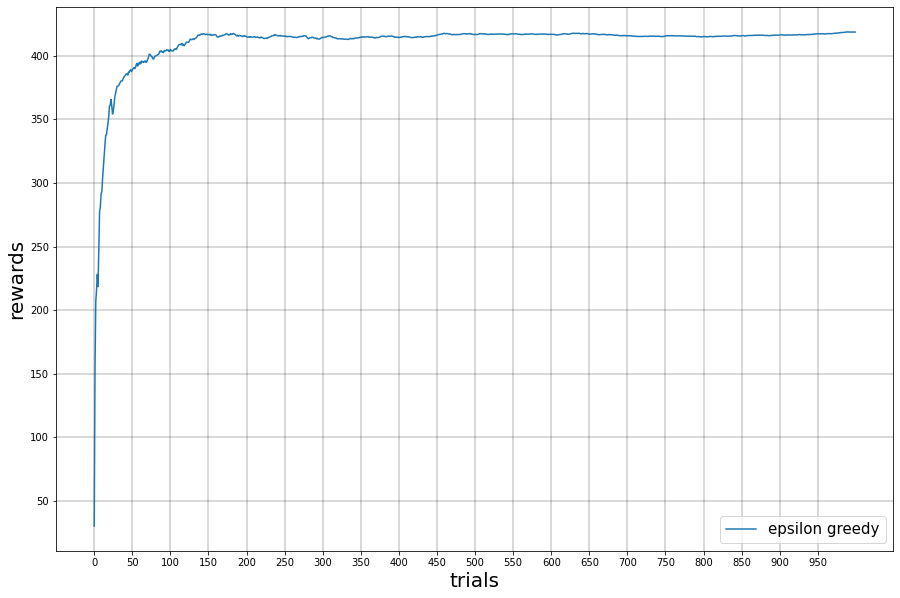

In [28]:
fig = plt.figure(figsize=(15, 10))
ax = fig.gca()
ax.set_xticks(np.arange(0, 1000, 50))

plt.plot(eps_mean_reward, label="epsilon greedy")

plt.xlabel("trials", fontsize = 20)
plt.ylabel("rewards", fontsize = 20)
plt.legend(loc='best',fontsize = 15)
plt.grid(color = 'black',linewidth = 0.3)
plt.show()

In [1]:
import os
os.system('jupyter nbconvert --to html HW2_Q2.ipynb')

0